In [1]:
import math
from PIL import Image, ImageEnhance, ImageFilter
from skimage.exposure import cumulative_distribution
import numpy as np
from skimage import data, img_as_float, img_as_ubyte, exposure, io, color
from skimage.filters import threshold_otsu
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2

import utils as u
from skimage.segmentation import random_walker
from tqdm import tqdm

- https://porespy.org/examples/metrics/tutorials/regionprops_3d.html
- здесь в конце есть сравнения расчета пористости по porespy и openpnm: https://openpnm.org/examples/applications/porosity.html

SNOW algorithm for regionprops3D: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.96.023307

Pore size distribution tutorial: https://porespy.org/examples/metrics/reference/pore_size_distribution.html

REV: https://porespy.org/examples/metrics/reference/representative_elementary_volume.html

In this hometask you will work with 3d-samples and find following properties:
- porosity
- pore size distribution
- surface area
- Euler number
- shape factor 
- and find representative elementary volume (REV)

1) Denoise and binarize the sample: (5 points)
    
- Take provided slice;
- Utilize techniques you got familiar during HW1 and HW2 (denoising, thresholding, half-toning, etc); You should decide by yourself which transformations are the most suitable;
- Elaborate on why you have chosen such transformations.

Sample shape: (400, 400, 400)


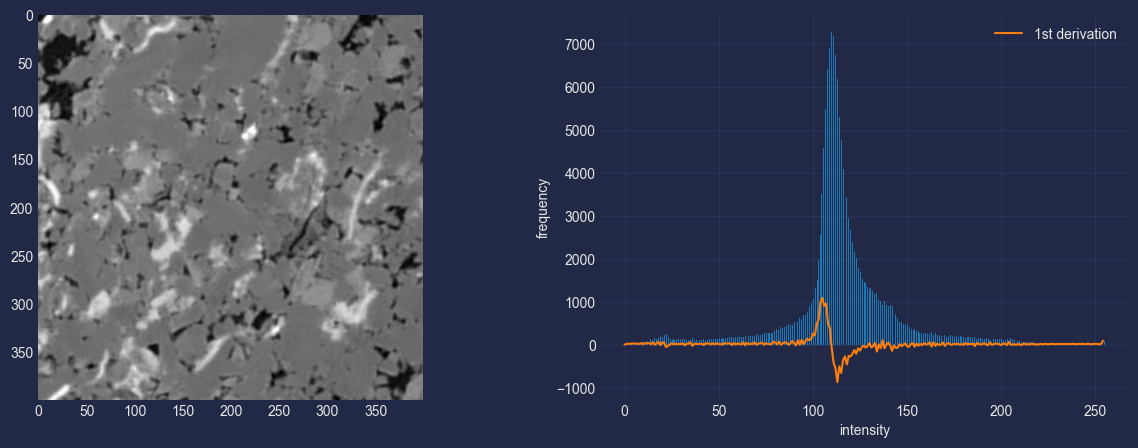

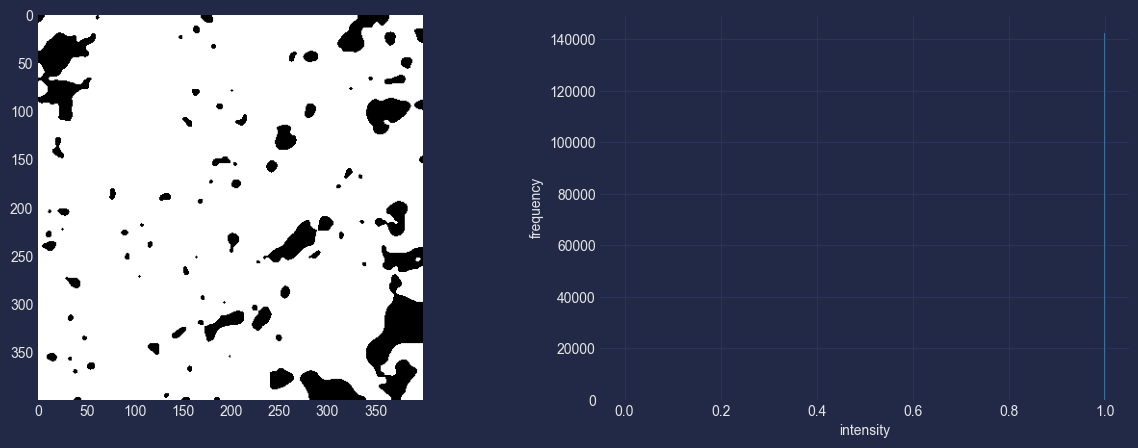

Manual calculation of a sample porosity  gives equals 0.1099


100%|██████████| 400/400 [02:35<00:00,  2.58it/s]


In [2]:
# your code here 

# uploading sample
sample = np.load('sample2.npy')
print(f'Sample shape: {sample.shape}')
u.plot_img_and_hist(sample[42], hist_with_diff=True)

def porosity_calc_manual(img, vis: bool = False):
    phi = 1 - np.count_nonzero(img)/img.size
    if vis:
        print(f'Manual calculation of a sample porosity  gives equals {phi :.4f}')
    return phi

def random_walker_2d(img, ths, beta = 10):
    markers = np.zeros(img.shape, dtype=np.uint8)
    markers[img < ths[0]] = 1
    markers[img > ths[1]] = 2
    labels = random_walker(img, markers, beta=beta, mode='bf')
    return labels // 2 

ths = (50, 120)
bin_slice = random_walker_2d(sample[42], ths)
u.plot_img_and_hist(bin_slice)
_ = porosity_calc_manual(bin_slice, vis=True)

def random_walker_3d(img, ths):
    res_x = []
    res_y, res_z = [], []
    if img.shape[0] == img.shape[1] and img.shape[1] == img.shape[2]:
        for i in tqdm(range(img.shape[0])):
            res_x.append(random_walker_2d(img[i, :, :],ths))
            # res_y.append(random_walker_2d(img[:, i, :],ths))
            # res_z.append(random_walker_2d(img[:, :, i],ths))
    res_x = np.array(res_x)
    # res_y, res_z = np.array(res_y), np.array(res_z)


    # res = np.median([res_x, res_y, res_z], axis=0)
    # del res_x, res_y, res_z
    res = res_x.astype(np.uint8)
    np.save('binarized_sample.npy', res)
    return res

sample = random_walker_3d(sample, ths)

In [16]:
# ps.visualization.set_mpl_style()
np.random.seed(1)

### Why I made this transformation?

Because our goal is take correctly binarized image and Randow Walker algorithm is a silver bullet in image segmentation task.

2) Complete following tasks: (10 points)
    
- Calculate porosity using porespy and manually and compare results; plot pore size distribution;
- Plot porosity profile;
- Calculate surface area;
- Calculate shape factor and plot histogram using surface area and pore volume from formula slide 8
- Plot REV (porosity vs volume);
- Plot REV (surface area vs volume) (for PhD students).

# Porosiry calculation: Manually, Using PoreSpy, Pore Size Distribution

Manual calculation of a sample porosity  gives equals 0.0747
Porespy porosity calculation: 0.0747
MAE: 0.0
MSE: 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

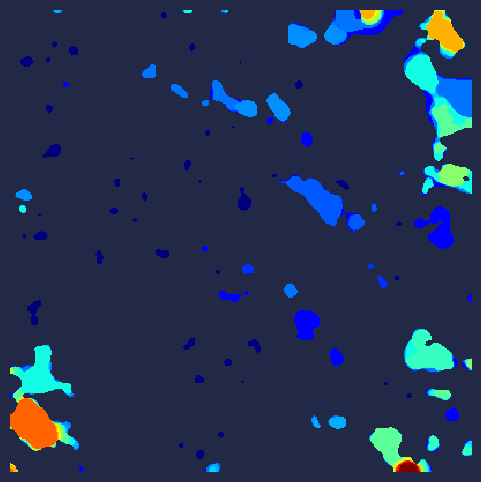

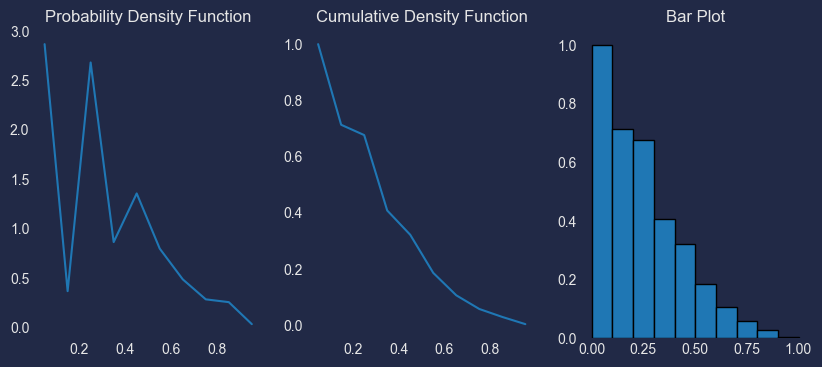

In [4]:
# your code here

# porosity manually
phi_manual = porosity_calc_manual(sample, vis = True)
# porosity porespy
phi_ps = 1 - ps.metrics.porosity(sample) #porespy calc require that 1 is the pore
print(f'Porespy porosity calculation: {phi_ps :.4f}')
# porosity two approach difference
print(f'MAE: {abs(phi_manual - phi_ps)}\nMSE: {np.linalg.norm(phi_manual - phi_ps)}')

# reverse, now 1 is a pore, 0 is a solid phase 
sample = np.where(sample == 1, 0, 1)

# pore size distribution

sizes = ps.filters.porosimetry(im=sample)
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(sizes[42]/sample[42], origin='lower', interpolation='none', cmap='jet')
ax.axis(False);
plt.show()

data = ps.metrics.pore_size_distribution(sizes)
fig, ax = plt.subplots(1, 3, figsize=[10, 4])
ax[0].plot(data.bin_centers, data.pdf)
ax[1].plot(data.bin_centers, data.cdf)
ax[2].bar(data.bin_centers, data.cdf, data.bin_widths, edgecolor='k')
ax[0].set_title("Probability Density Function")
ax[1].set_title("Cumulative Density Function")
ax[2].set_title('Bar Plot');
plt.show()


### Two approach comparing

In my case there is *no difference* between two approach of porosity computing, BUT if I am correct, manual approach does not take into account **closed porosity** existance. PoreSpy can work with correctly with closed porosity.

# Porosity profile

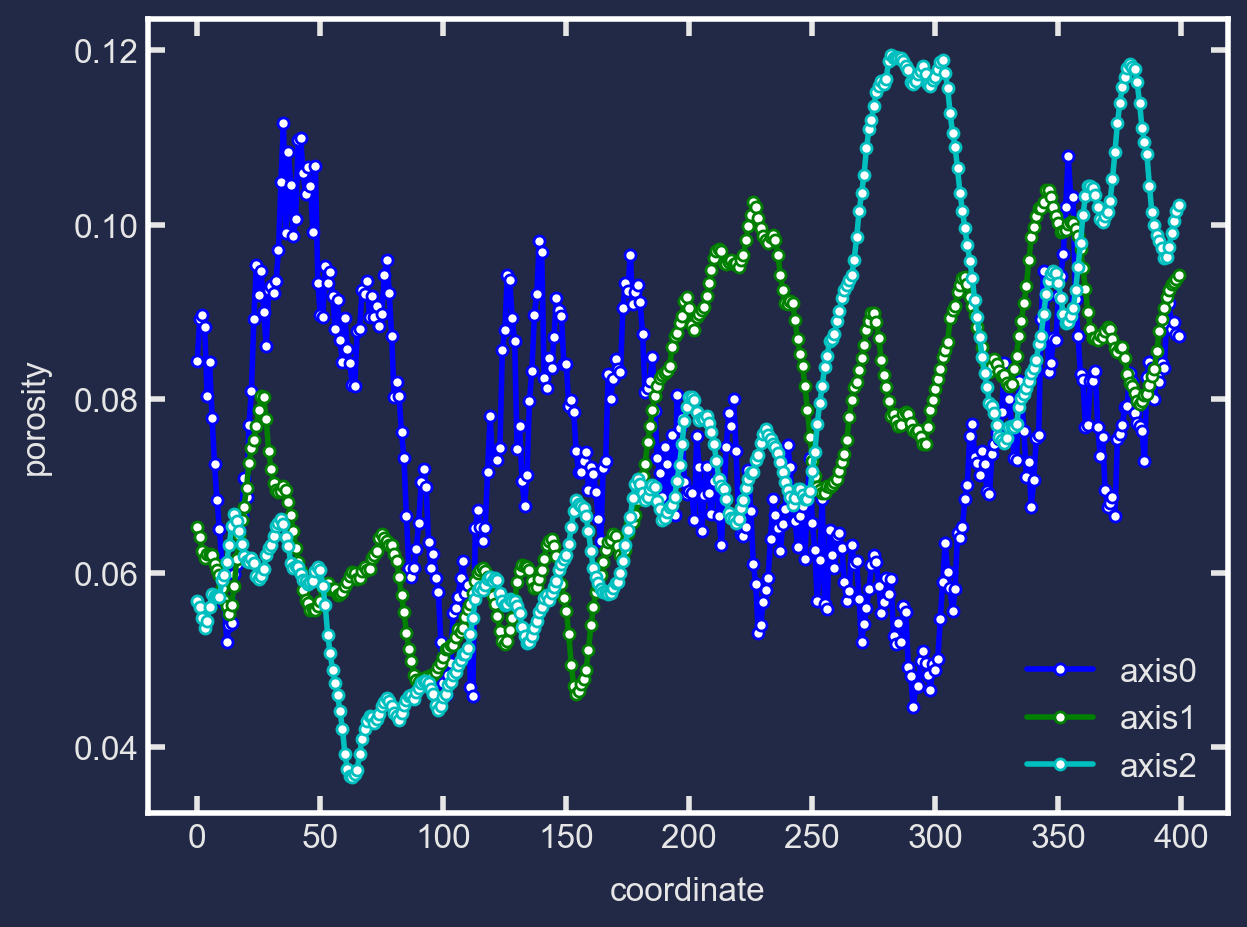

In [17]:
prf0 = ps.metrics.porosity_profile(sample, axis=0)
prf1 = ps.metrics.porosity_profile(sample, axis=1)
prf2 = ps.metrics.porosity_profile(sample, axis=2)
plt.plot(prf0, 'b.-', label='axis0')
plt.plot(prf1, 'g.-', label='axis1')
plt.plot(prf2, 'c.-', label='axis2')
# plt.plot([0, 50], [0.65, 0.65], 'r--')
plt.xlabel('coordinate')
plt.ylabel('porosity')
# plt.ylim([0.08, 0.2]);
plt.legend()
plt.show()

# Surface area

In [6]:
snow = ps.filters.snow_partitioning(im=sample)
regions = snow.regions*snow.im

0it [00:00, ?it/s]

In [7]:
props = ps.metrics.regionprops_3D(regions)
df = ps.metrics.props_to_DataFrame(props)

In [8]:
df

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,feret_diameter_max,area_filled,axis_major_length,axis_minor_length,solidity
0,1,156,315,1.129527,124.071068,178,156,315,178,6.678957,1,0.495238,10.488088,156,10.141347,4.737333,0.876404
1,2,461,1960,0.498320,579.130737,804,461,1960,804,9.584455,1,0.235204,22.912878,461,21.735049,5.283255,0.573383
2,3,491,2040,0.539241,558.156250,795,491,2040,795,9.788007,1,0.240686,20.223748,491,18.349457,4.877139,0.617610
3,4,166,330,0.883406,165.346786,191,166,330,191,6.818725,1,0.503030,11.401754,166,10.903033,2.918881,0.869110
4,5,175,396,0.836144,180.951324,213,175,396,213,6.939792,1,0.441919,11.874342,175,11.154524,5.701521,0.821596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,4253,5415,34476,0.579635,2572.735352,12091,5415,34476,12091,21.787126,2,0.157066,56.780278,5415,37.262591,13.126060,0.447854
4253,4254,3741,14688,0.571709,2038.453003,6800,3741,14688,6800,19.260299,1,0.254698,33.719431,3741,25.706101,15.747727,0.550147
4254,4255,813,3456,0.425386,990.287231,1434,813,3456,1434,11.579700,2,0.235243,24.738634,813,22.886970,6.399905,0.566946
4255,4256,333,5313,0.452019,513.992554,1788,333,5313,1788,8.599672,2,0.062676,29.034462,333,24.775380,10.139926,0.186242


In [9]:
sph = ps.metrics.prop_to_image(regionprops=props, shape=regions.shape, prop='surface_area')

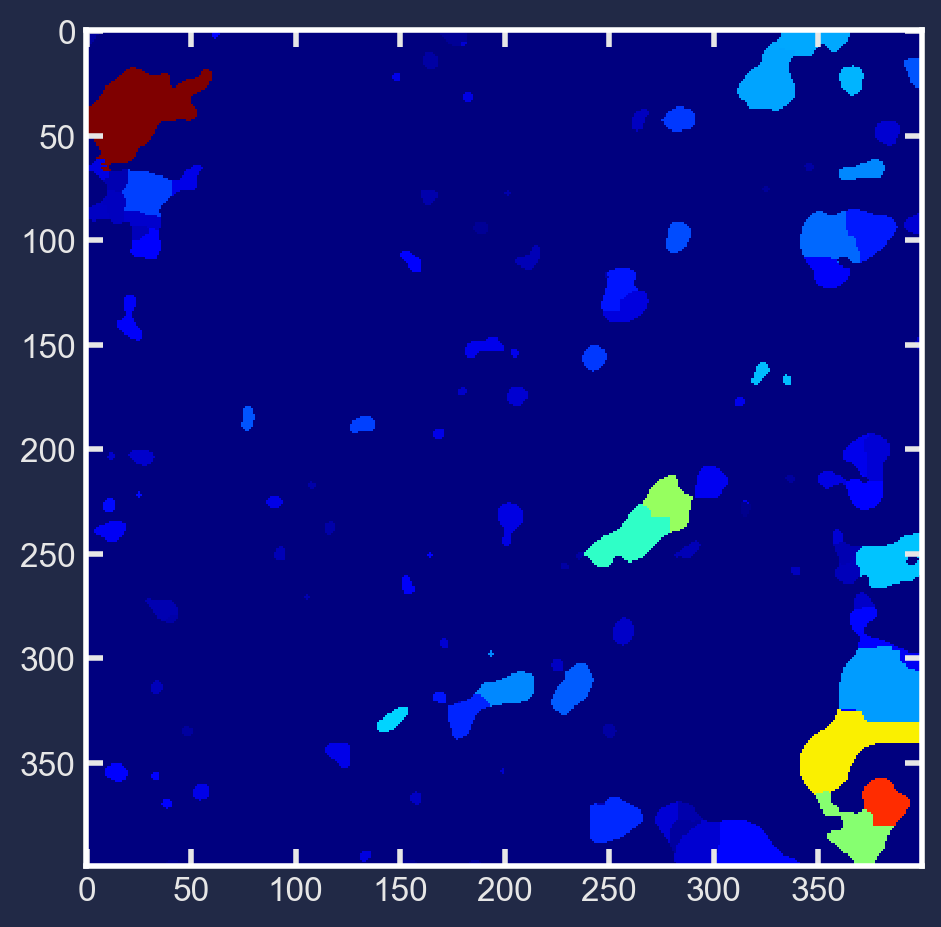

In [18]:
fig, ax = plt.subplots()
ax.imshow((sph + 0.5*(~sample))[42] , cmap=plt.cm.jet);
plt.show()

# REV

In [11]:
profile = ps.metrics.representative_elementary_volume(im=sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

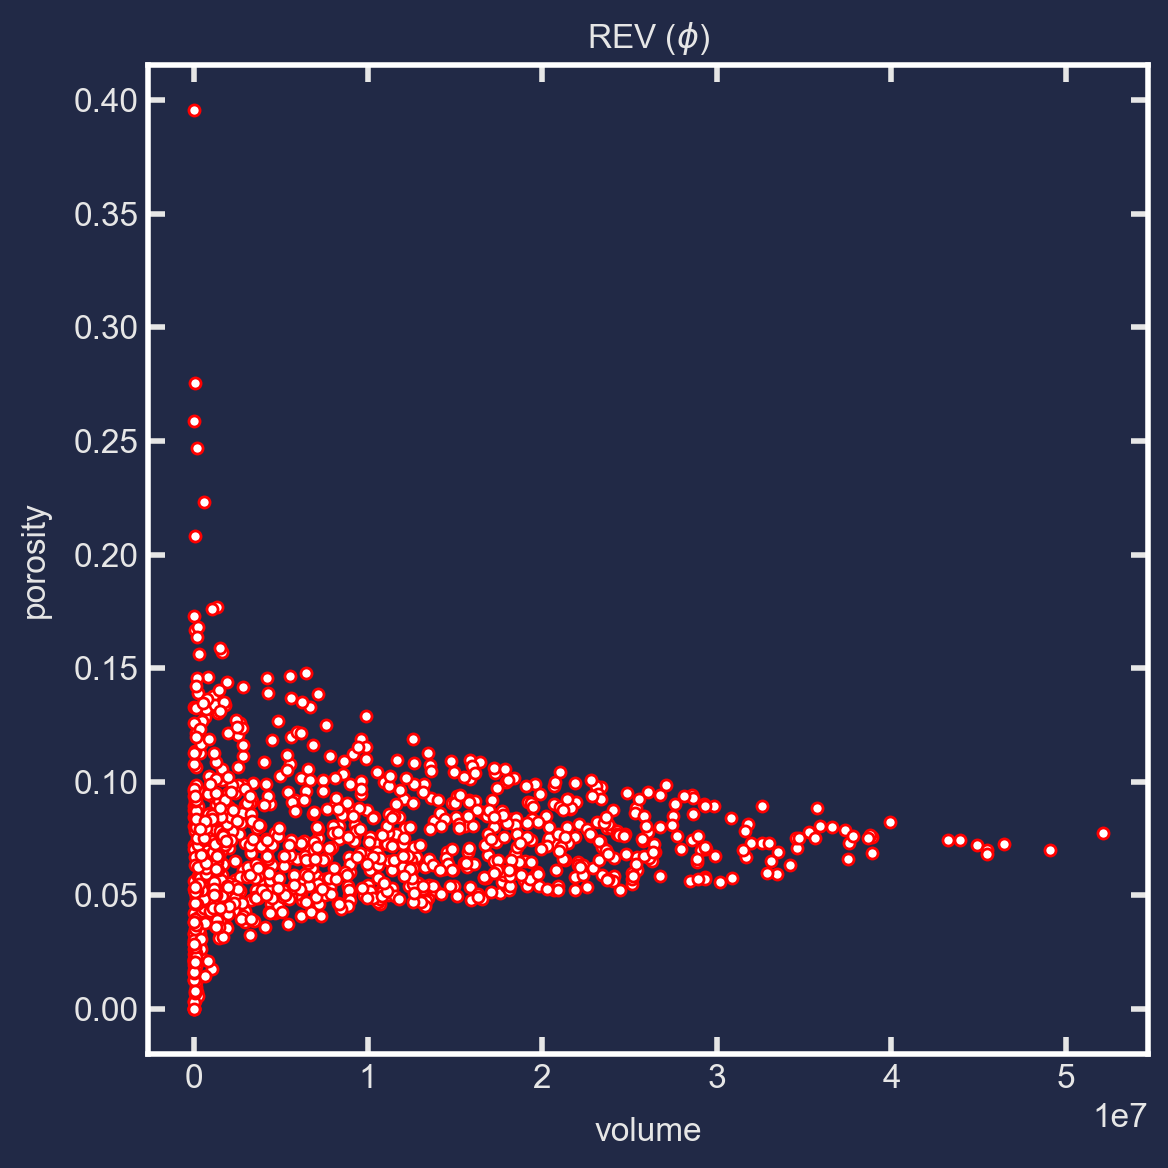

In [19]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(profile.volume, profile.porosity, 'r.')
plt.title(fr'REV ($\phi$)')
ax.set_xlabel("volume")
ax.set_ylabel("porosity");
plt.show()

In [13]:
def rev_props(prop_arr, steps):
    res_dict = {}
    for step in steps:
        res_dict[step] = []
        for i in tqdm(range(prop_arr.shape[0]//step)):
            for j in range(prop_arr.shape[1]//step):
                for k in range(prop_arr.shape[2]//step):
                    ev = prop_arr[i*step:(i+1)*step, j*step:(j+1)*step,i*step:(j+1)*step]
                    res_dict[step].append(np.sum(ev)/ev.size)
    return res_dict

100%|██████████| 1/1 [00:00<00:00, 30.54it/s]


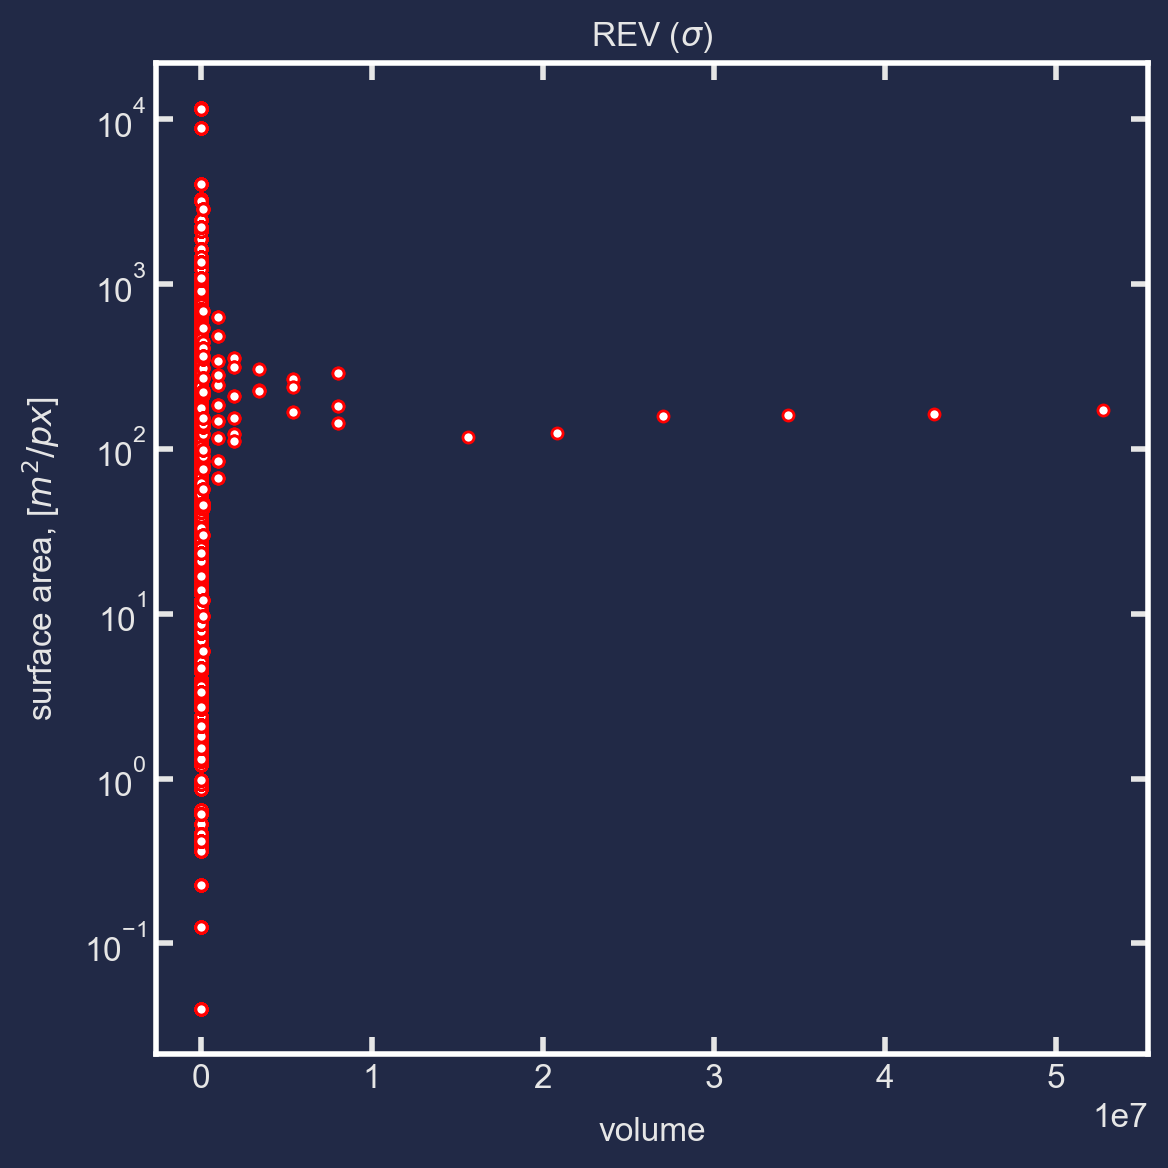

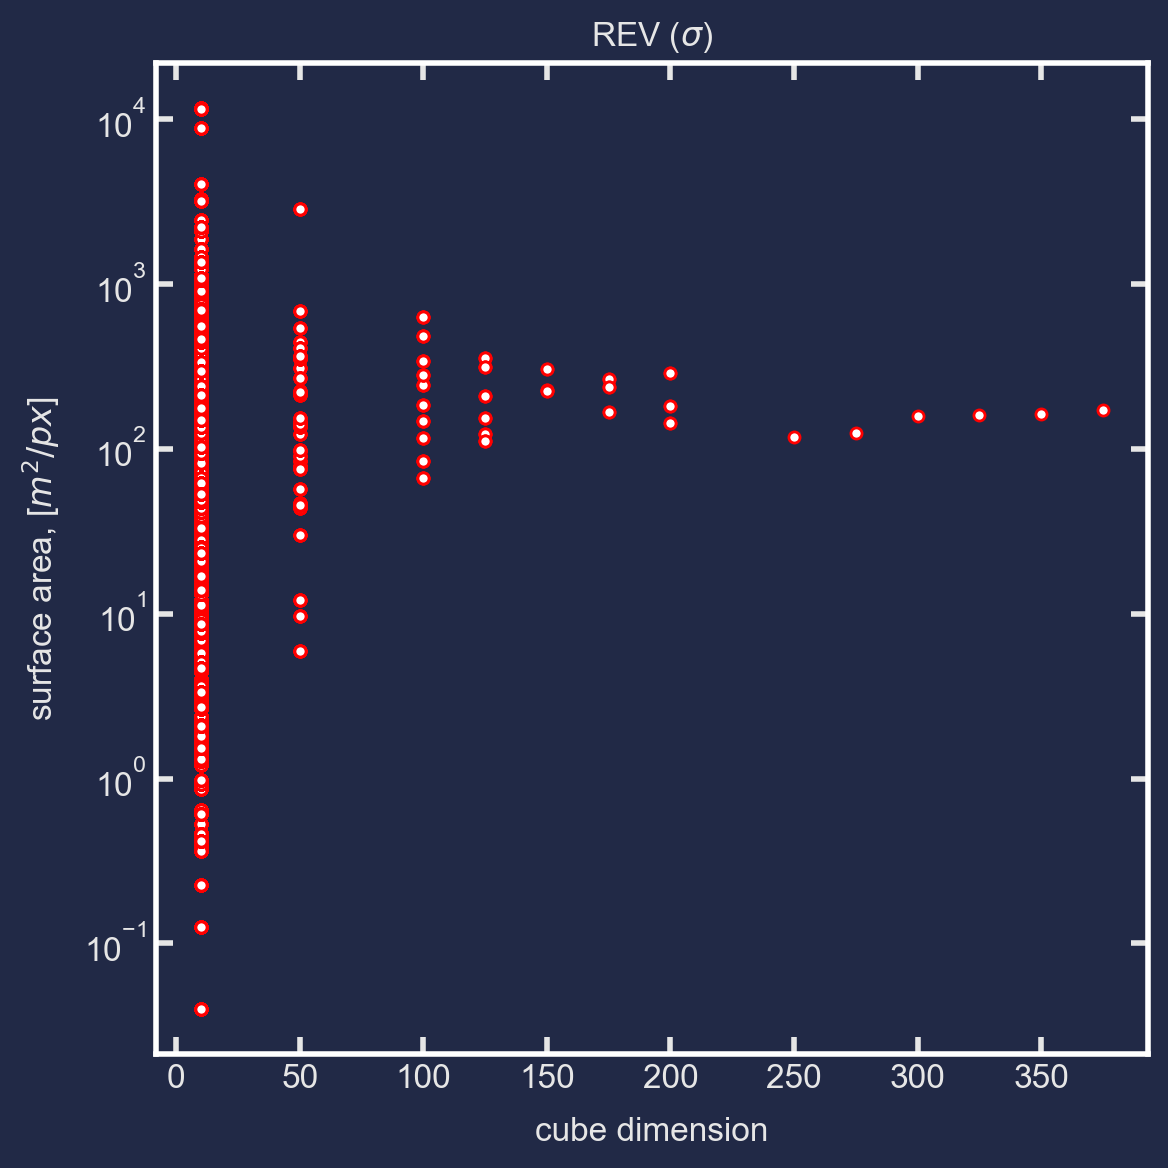

In [28]:
sph_res_dict = rev_props(sph, [10, 50, 100, 125, 150, 175,
                               200, 250, 275, 300, 325, 350, 375])

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
for key, value in sph_res_dict.items():
    ax.plot([key**3 for _ in range(len(value))], value, 'r.')
plt.title(fr'REV ($\sigma$)')
ax.set_xlabel(fr"volume")
ax.set_ylabel("surface area, [$m^2 / px$]");
plt.yscale('log')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
for key, value in sph_res_dict.items():
    ax.plot([key for _ in range(len(value))], value, 'r.')
plt.title(fr'REV ($\sigma$)')
ax.set_xlabel(fr"cube dimension")
ax.set_ylabel("surface area, [$m^2 / px$]");
plt.yscale('log')
plt.show()

In [24]:
pass

